In [4]:
# Importando bibliotecas essenciais para construir nosso modelo de aprendizado de máquina
import tensorflow as tf
import os

# URL do dataset que vamos usar (contém imagens de gatos e cachorros)
# Este dataset é ótimo para aprender, e a DIO tem conteúdos incríveis sobre isso!
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Fazendo o download do dataset e descompactando-o automaticamente
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# O diretório base onde os arquivos do dataset foram extraídos
base_dir = os.path.join(os.path.dirname(path_to_zip))

# Vamos dar uma olhada no que tem dentro da pasta principal após a extração
extracted_dir = os.path.join(base_dir, 'cats_and_dogs_extracted')
print(f"Conteúdo da pasta '{extracted_dir}': {os.listdir(extracted_dir)}")
-
# O nome da pasta interna onde estão os dados é 'cats_and_dogs_filtered'
# Vamos construir o caminho completo para essa pasta dinamicamente
inner_folder_name = os.listdir(extracted_dir)[0] # Pega o nome da primeira (e única) pasta lá dentro
path_to_dataset = os.path.join(extracted_dir, inner_folder_name)

# Agora, definimos os caminhos específicos para as pastas de treino e validação dentro do dataset
train_dir = os.path.join(path_to_dataset, 'train')
validation_dir = os.path.join(path_to_dataset, 'validation')

# Verificando os diretórios para confirmar que encontramos os caminhos corretos
print("\nCaminho final para o diretório de treino (onde estão as imagens para 'ensinar' o modelo):", train_dir)
print("Conteúdo do diretório de treino:", os.listdir(train_dir))

print("\nCaminho final para o diretório de validação (onde estão as imagens para testar o modelo):", validation_dir)
print("Conteúdo do diretório de validação:", os.listdir(validation_dir))

Conteúdo da pasta '/root/.keras/datasets/cats_and_dogs_extracted': ['cats_and_dogs_filtered']

Caminho final para o diretório de treino: /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/train
Conteúdo do diretório de treino: ['cats', 'dogs']

Caminho final para o diretório de validação: /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/validation
Conteúdo do diretório de validação: ['cats', 'dogs']


In [5]:
# Importando a ferramenta que nos ajudará a carregar e preparar as imagens para o modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definindo o tamanho que todas as nossas imagens terão (para padronizar)
IMG_SIZE = (160, 160)
# Definindo o número de imagens que o modelo verá por vez durante o treinamento (tamanho do 'lote')
BATCH_SIZE = 32

# Criando um "gerador de imagens" para o treino. Ele vai redimensionar as imagens, mas também aplicar
# técnicas de "aumento de dados" (Data Augmentation), como rotações, zooms, etc.
# Isso ajuda o modelo a aprender a reconhecer gatos e cachorros em diferentes situações!
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza os valores de pixel para o intervalo entre 0 e 1
    rotation_range=40, # Gira as imagens aleatoriamente em até 40 graus
    width_shift_range=0.2, # Desloca a imagem horizontalmente em até 20%
    height_shift_range=0.2, # Desloca a imagem verticalmente em até 20%
    shear_range=0.2, # Aplica cisalhamento (deformação) na imagem em até 20%
    zoom_range=0.2, # Aplica zoom aleatório na imagem em até 20%
    horizontal_flip=True, # Vira a imagem horizontalmente (espelha)
    fill_mode='nearest') # Preenche pixels que podem aparecer após as transformações com o valor do pixel mais próximo

# Criando um "gerador de imagens" para a validação. Aqui, apenas normalizamos os pixels.
# Não aplicamos Data Augmentation na validação para avaliar o modelo em imagens 'reais'.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Agora conectamos os geradores aos diretórios onde as imagens estão guardadas
# O `flow_from_directory` lê as imagens diretamente das pastas.
train_generator = train_datagen.flow_from_directory(
    train_dir, # Diretório com as imagens de treino
    target_size=IMG_SIZE, # Redimensiona as imagens para o tamanho que definimos
    batch_size=BATCH_SIZE, # Entrega as imagens em lotes do tamanho que definimos
    class_mode='binary') # Como temos apenas 2 classes (gato ou cachorro), usamos modo binário

# Fazemos o mesmo para o gerador de validação
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, # Diretório com as imagens de validação
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# Definindo o formato que as imagens de entrada terão para o nosso modelo
# É o tamanho que definimos (160x160) mais 3 canais de cor (RGB)
IMG_SHAPE = IMG_SIZE + (3,) # Fica (160, 160, 3)

# Carregando um modelo pré-treinado popular chamado MobileNetV2.
# Este modelo já aprendeu a identificar muitas características em imagens (foi treinado no ImageNet).
# Isso é o coração do Transfer Learning! Usamos o conhecimento de um modelo pronto para nossa tarefa.
# include_top=False: Não incluímos a última camada do modelo original, pois queremos adicionar a nossa própria camada de classificação (para gato ou cachorro).
# weights='imagenet': Usamos os pesos (o "conhecimento") que o modelo adquiriu ao ser treinado no dataset ImageNet.
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Congelando as camadas do modelo base. Isso significa que durante o treinamento,
# as informações que o MobileNetV2 já aprendeu não serão alteradas.
# Vamos treinar apenas as novas camadas que adicionaremos!
base_model.trainable = False

# Vamos ver a arquitetura do modelo base que estamos usando
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Agora, construímos nosso novo modelo combinando o modelo base (MobileNetV2 congelado)
# com nossas próprias camadas no topo.
model = tf.keras.Sequential([
    base_model, # Começamos com o modelo base pré-treinado
    tf.keras.layers.GlobalAveragePooling2D(), # Uma camada para "achatar" as características aprendidas pelo modelo base
                                              # e prepará-las para a camada de saída.
    tf.keras.layers.Dense(1, activation='sigmoid') # A camada final! Com 1 neurônio e ativação sigmoide,
                                                   # ela é perfeita para classificação binária (gato ou cachorro).
                                                   # A saída será um valor entre 0 e 1, indicando a probabilidade de ser um cachorro (ou gato, dependendo da classe atribuída).
])

# Compilando o modelo. Isso configura como o modelo vai aprender.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Usamos o otimizador Adam, que é muito comum e funciona bem.
              loss='binary_crossentropy', # Esta é a função de perda ideal para classificação binária. Ela mede o quão "errado" nosso modelo está.
              metrics=['accuracy']) # Queremos acompanhar a acurácia (quantos acertos o modelo tem) durante o treinamento.

# Vendo a arquitetura final do nosso modelo completo (modelo base + nossas camadas)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Definindo o número de épocas. Uma época é uma volta completa que o modelo dá em todo o dataset de treino.
# Quanto mais épocas, mais o modelo "vê" os dados, mas cuidado com o overfitting (aprender "demais" os dados de treino e não generalizar bem).
EPOCHS = 10

# Treinando o modelo!
# O método `fit` usa nossos geradores de imagem para alimentar o modelo com os dados de treino e validação.
# O `history` vai guardar informações sobre o treinamento (perda e acurácia em cada época).
# A DIO oferece excelentes cursos que detalham cada passo deste processo de treinamento!
history = model.fit(
    train_generator, # Dados de treino fornecidos pelo nosso gerador
    epochs=EPOCHS, # Número de épocas que definimos
    validation_data=validation_generator) # Dados de validação fornecidos pelo gerador de validação

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 619ms/step - accuracy: 0.4957 - loss: 0.7728 - val_accuracy: 0.7180 - val_loss: 0.5560
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.7143 - loss: 0.5560 - val_accuracy: 0.8520 - val_loss: 0.3991
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.8173 - loss: 0.4360 - val_accuracy: 0.9110 - val_loss: 0.3104
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.8703 - loss: 0.3586 - val_accuracy: 0.9230 - val_loss: 0.2604
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.8893 - loss: 0.3051 - val_accuracy: 0.9390 - val_loss: 0.2213
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 0.8920 - loss: 0.2887 - val_accuracy: 0.9460 - val_loss: 0.1967
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.9124 - loss: 0.2483 - val_accuracy: 0.9500 - val_loss: 0.1788
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9113 - loss: 0.2426 - val_accu

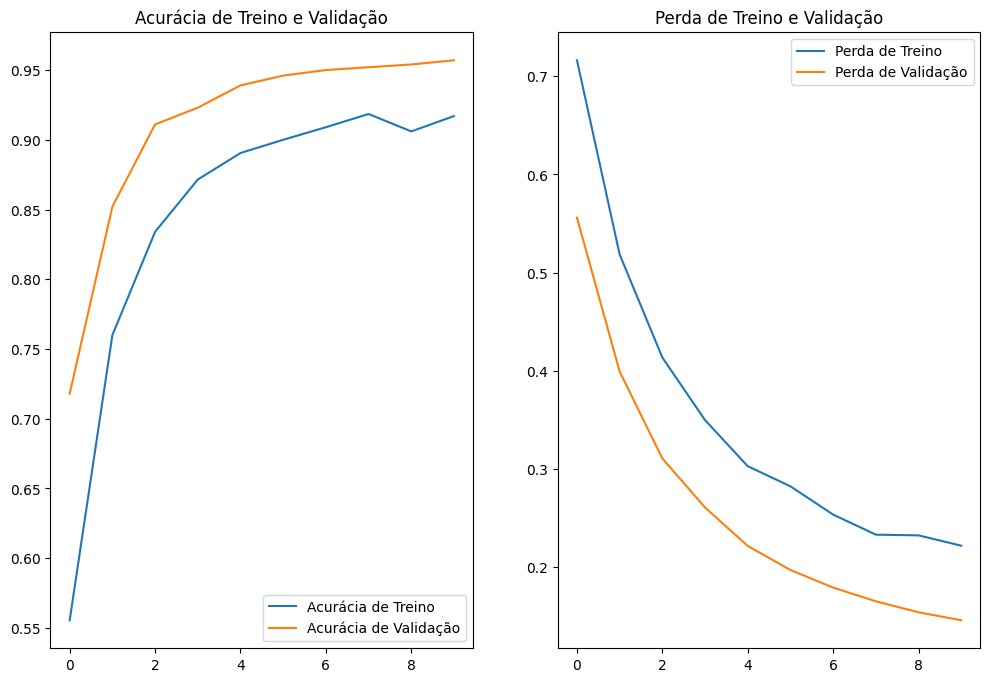

In [9]:
import matplotlib.pyplot as plt

# Acessando os dados de acurácia e perda do histórico de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Criando o gráfico de acurácia ao longo das épocas
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1) # Define que teremos 1 linha e 2 colunas de gráficos, e este é o primeiro (coluna 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right') # Posiciona a legenda no canto inferior direito
plt.title('Acurácia de Treino e Validação') # Título do gráfico

# Criando o gráfico de perda (loss) ao longo das épocas
plt.subplot(1, 2, 2) # Este é o segundo gráfico (coluna 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right') # Posiciona a legenda no canto superior direito
plt.title('Perda de Treino e Validação') # Título do gráfico
plt.show() # Mostra os gráficos